In [16]:
%run Module-2-helper.py

### For Visualization, 2-D PCA transfer the data

In [3]:
X, y = sklearn.datasets.make_classification(n_samples=5000, n_features=2, n_informative=2,
                                            n_redundant=0, n_repeated=0, n_classes=2,
                                            n_clusters_per_class=1,
                                            weights=[0.98, 0.02],
                                            class_sep=0.5, random_state=1)

dataset_df = pd.DataFrame({'X1':X[:,0],'X2':X[:,1], 'Y':y})


In [26]:
dataset_df

,X1,X2,Y
0,1.248388,-1.181769,0
1,0.138149,0.492026,0
2,1.400027,-0.080835,1
3,0.015969,1.396646,0
4,0.339365,0.414270,0
...,...,...,...
4995,0.687166,0.517274,0
4996,0.907563,0.272494,0
4997,-1.148535,0.203596,0
4998,1.073027,-0.404024,0


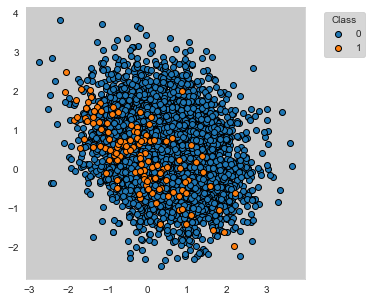

In [5]:
fig_distribution, ax = plt.subplots(1, 1, figsize=(5,5))

groups = dataset_df.groupby('Y')
for name, group in groups:
    ax.scatter(group.X1, group.X2, edgecolors='k', label=name,alpha=1,marker='o')
    
ax.legend(loc='upper left', 
          bbox_to_anchor=(1.05, 1),
          title="Class")

## Decision-Trees - Tacking Imbalance using the Cost-Sensitive Learning
---

In [6]:
classifier = sklearn.tree.DecisionTreeClassifier(max_depth=5,class_weight={0:1,1:1},random_state=0)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [7]:
cv_results_ = sklearn.model_selection.cross_validate(classifier, X, y, cv=cv,
                                                     scoring=['roc_auc',
                                                              'average_precision',
                                                              'balanced_accuracy'],
                                                     return_estimator=True)

In [8]:
results = round(pd.DataFrame(cv_results_),3)
results

,fit_time,score_time,estimator,test_roc_auc,test_average_precision,test_balanced_accuracy
0,0.004,0.002,"DecisionTreeClassifier(class_weight={0: 1, 1: ...",0.651,0.059,0.497
1,0.004,0.001,"DecisionTreeClassifier(class_weight={0: 1, 1: ...",0.783,0.086,0.499
2,0.004,0.001,"DecisionTreeClassifier(class_weight={0: 1, 1: ...",0.719,0.060,0.498
3,0.003,0.001,"DecisionTreeClassifier(class_weight={0: 1, 1: ...",0.692,0.059,0.500
4,0.003,0.001,"DecisionTreeClassifier(class_weight={0: 1, 1: ...",0.701,0.051,0.499


In [9]:
results_mean = list(results.mean().values)
results_std = list(results.std().values)

pd.DataFrame([[str(round(results_mean[i],3))+'+/-'+str(round(results_std[i],3)) for i in range(len(results))]],
            columns=['Fit time (s)','Score time (s)','AUC ROC','Average Precision','Balanced accuracy'])

/var/folders/vb/1nttnwc116l2y0t3v_x1pqqc0000gn/T/ipykernel_9109/3263762727.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_mean = list(results.mean().values)
/var/folders/vb/1nttnwc116l2y0t3v_x1pqqc0000gn/T/ipykernel_9109/3263762727.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_std = list(results.std().values)


,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
0,0.004+/-0.001,0.001+/-0.0,0.709+/-0.048,0.063+/-0.013,0.499+/-0.001


In [11]:
classifier_0 = cv_results_['estimator'][0]

In [12]:
# Retrieve the indices used for the training and testing of the first fold of the cross-validation
(train_index, test_index) = next(cv.split(X, y))

# Recreate the train and test DafaFrames from these indices
train_df = pd.DataFrame({'X1':X[train_index,0], 'X2':X[train_index,1], 'Y':y[train_index]})
test_df = pd.DataFrame({'X1':X[test_index,0], 'X2':X[test_index,1], 'Y':y[test_index]})
input_features = ['X1','X2', 'X3']
output_feature = 'Y'

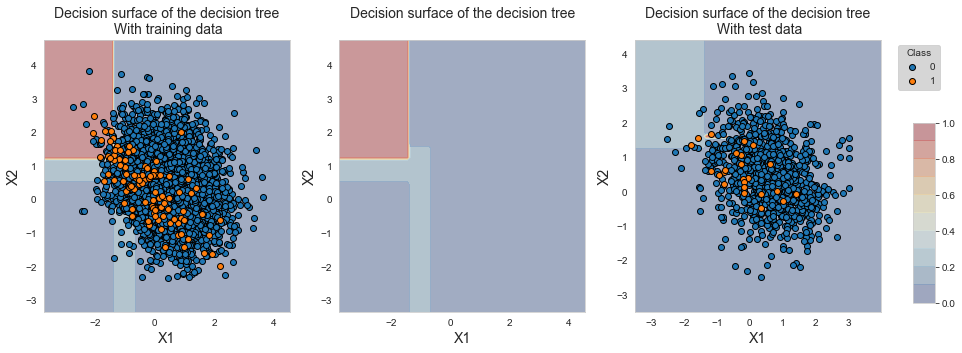

In [14]:
fig_decision_boundary, ax = plt.subplots(1, 3, figsize=(5*3,5))

plot_decision_boundary_classifier(ax[0], classifier_0,
                                  train_df,
                                  title="Decision surface of the decision tree\n With training data",
                                  plot_training_data=True)

plot_decision_boundary_classifier(ax[1], classifier_0,
                                  train_df,
                                  title="Decision surface of the decision tree\n",
                                  plot_training_data=False)


plot_decision_boundary_classifier(ax[2], classifier_0,
                                  test_df,
                                  title="Decision surface of the decision tree\n With test data",
                                  plot_training_data=True)

ax[-1].legend(loc='upper left', 
              bbox_to_anchor=(1.05, 1),
              title="Class")

sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlBu_r, norm=plt.Normalize(vmin=0, vmax=1))
cax = fig_decision_boundary.add_axes([0.93, 0.15, 0.02, 0.5])
fig_decision_boundary.colorbar(sm, cax=cax, alpha=0.3, boundaries=np.linspace(0, 1, 11))

/Users/dayevan/Desktop/Final-Module-2/Module-2-helper.py:662: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_mean = list(results.mean().values)
/Users/dayevan/Desktop/Final-Module-2/Module-2-helper.py:663: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_std = list(results.std().values)


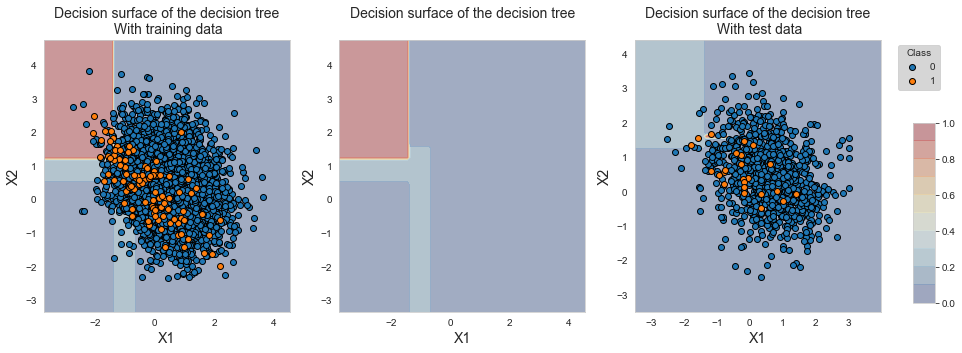

In [17]:
classifier = sklearn.tree.DecisionTreeClassifier(max_depth=5,class_weight={0:1,1:1},random_state=0)


(results_df_dt_baseline, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, 
                                                                                     X, y, 
                                                                                     n_splits=5,
                                                                                     strategy_name="Decision tree - Baseline")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

### Adding Cost-Sensitive

In [18]:
IR=0.05/0.95
class_weight={0:IR,1:1}

/Users/dayevan/Desktop/Final-Module-2/Module-2-helper.py:662: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_mean = list(results.mean().values)
/Users/dayevan/Desktop/Final-Module-2/Module-2-helper.py:663: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_std = list(results.std().values)


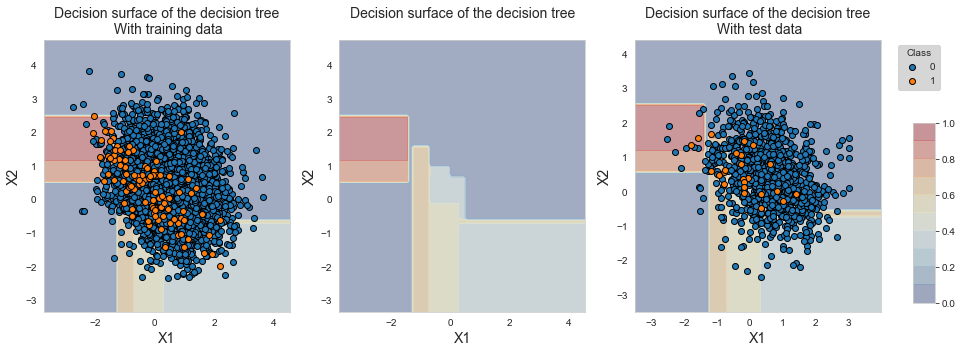

In [19]:
classifier = sklearn.tree.DecisionTreeClassifier(max_depth=5,class_weight=class_weight,random_state=0)

(results_df_dt_cost_sensitive, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, 
                                                                         X, y, 
                                                                         n_splits=5,
                                                                         strategy_name="Decision tree - Cost-sensitive")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

In [20]:
pd.concat([results_df_dt_baseline, 
           results_df_dt_cost_sensitive])

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Decision tree - Baseline,0.003+/-0.001,0.001+/-0.0,0.709+/-0.048,0.063+/-0.013,0.499+/-0.001
Decision tree - Cost-sensitive,0.003+/-0.0,0.001+/-0.0,0.652+/-0.074,0.061+/-0.021,0.602+/-0.039


# Same for the Logistic Regreesion 

/Users/dayevan/Desktop/Final-Module-2/Module-2-helper.py:662: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_mean = list(results.mean().values)
/Users/dayevan/Desktop/Final-Module-2/Module-2-helper.py:663: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_std = list(results.std().values)


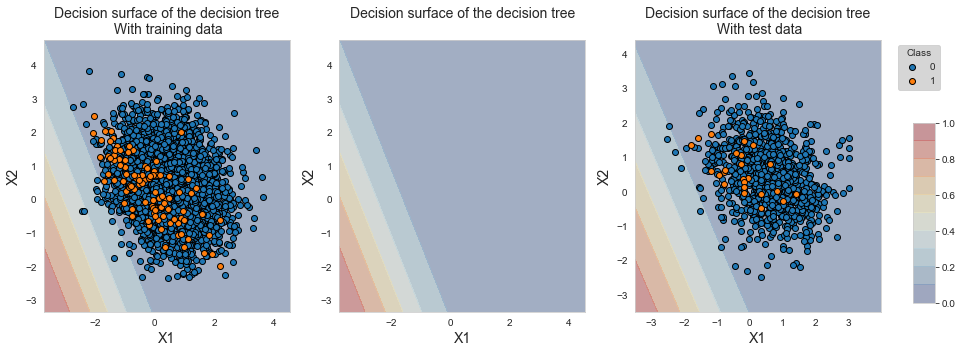

In [21]:
classifier = sklearn.linear_model.LogisticRegression(C=1,class_weight={0:1,1:1},random_state=0)

(results_df_lr_baseline, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, 
                                                                          X, y, 
                                                                          n_splits=5,
                                                                          strategy_name="Logistic regression - Baseline")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

In [22]:
results_df_lr_baseline

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Logistic regression - Baseline,0.003+/-0.001,0.001+/-0.0,0.752+/-0.033,0.074+/-0.018,0.5+/-0.0


### Adding Cost-Sensitive

/Users/dayevan/Desktop/Final-Module-2/Module-2-helper.py:662: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_mean = list(results.mean().values)
/Users/dayevan/Desktop/Final-Module-2/Module-2-helper.py:663: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_std = list(results.std().values)


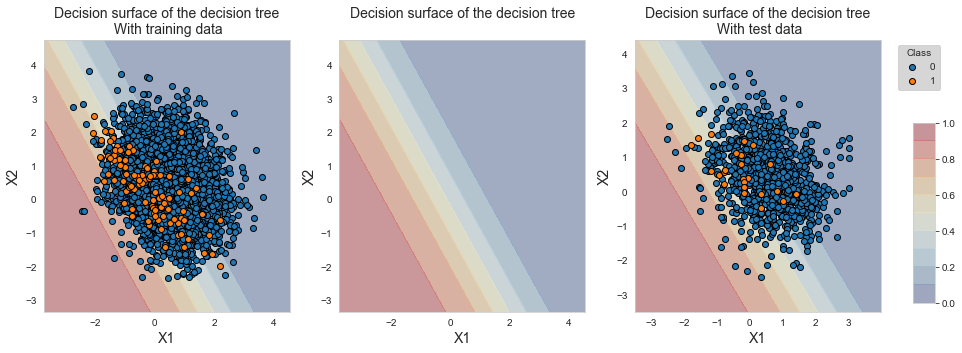

In [23]:
classifier = sklearn.linear_model.LogisticRegression(C=1,class_weight={0:IR,1:1},random_state=0)

(results_df_lr_cost_sensitive, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, 
                                                                         X, y, 
                                                                         n_splits=5,
                                                                         strategy_name="Logistic regression - Cost-sensitive")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

In [24]:
pd.concat([results_df_lr_baseline, results_df_lr_cost_sensitive])

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Logistic regression - Baseline,0.003+/-0.001,0.001+/-0.0,0.752+/-0.033,0.074+/-0.018,0.5+/-0.0
Logistic regression - Cost-sensitive,0.002+/-0.0,0.001+/-0.0,0.759+/-0.029,0.066+/-0.014,0.623+/-0.027


In [25]:
results_df = pd.concat([results_df_dt_baseline,
                        results_df_dt_cost_sensitive,
                        results_df_lr_baseline,
                        results_df_lr_cost_sensitive])
results_df

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Decision tree - Baseline,0.003+/-0.001,0.001+/-0.0,0.709+/-0.048,0.063+/-0.013,0.499+/-0.001
Decision tree - Cost-sensitive,0.003+/-0.0,0.001+/-0.0,0.652+/-0.074,0.061+/-0.021,0.602+/-0.039
Logistic regression - Baseline,0.003+/-0.001,0.001+/-0.0,0.752+/-0.033,0.074+/-0.018,0.5+/-0.0
Logistic regression - Cost-sensitive,0.002+/-0.0,0.001+/-0.0,0.759+/-0.029,0.066+/-0.014,0.623+/-0.027
